In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
from functools import partial


In [469]:
def fitzhugh_nagumo(x, t, a, b,eps, I):
    """Time derivative of the Fitzhugh-Nagumo neural model.
    Args:
       x (array size 2): [Membrane potential, Recovery variable]
       a, b (float): Parameters.
       eps (float): 1/Time scale.
       t (float): Time (Not used: autonomous system)
       I (float): Constant stimulus current. 
    Return: dx/dt (array size 2)
    """
    return np.array([x[0] - x[0]**3/3 - x[1] + I, 
                     (x[0] + a - b * x[1])*eps])

In [470]:
def check_parameters(a, b, eps):
    if 1 - (2 * b / 3) < a < 1 and 0 < b < 1 and b > eps**(2):
        return True
    else:
        return False

def check_scenarios(scenarios):
    for i, scenario in enumerate(scenarios):
        a = scenario["a"]
        b = scenario["b"]
        eps = scenario["eps"]
        if not check_parameters(a, b, eps):
            return False, i
    return True, None


In [527]:
# Implement the flow of the Fitzhugh-Nagumo model.
# And simulate some trajectories. 
# Try to use small perturbation of the resting potential as inital conditions. 
I_vals = [0, 0.32, 0.5]
scenarios = [
     {"a":.7, "b":.8, "eps":0.08, "I":0},
     {"a":.7, "b":.8, "eps":0.08, 'I': -0.4},
     {"a":.7, "b":.8, "eps":0.08, "I":-0.5}
]
time_span = np.linspace(0, 200, num=1500)
success, index = check_scenarios(scenarios)
if success:
    print("Tutti gli scenari soddisfano la relazione.")
else:
    print(f"Lo scenario {index + 1} non soddisfa la relazione.")

Tutti gli scenari soddisfano la relazione.


In [540]:
def get_displacement(param, dmax = 0.5 ,time_span=np.linspace(0,200, 1000), number=20):
    # We start from the resting point...
    init_cond=[-2,-1.6]
    ic = scipy.integrate.odeint(partial(fitzhugh_nagumo, **param),
                                                      y0 = init_cond,
                                                      t= np.linspace(0,999, 1000))[-1]
    # and do some displacement of the potential. 
    traj = [] 
    for displacement in np.linspace(0,dmax, number):
        traj.append(scipy.integrate.odeint(partial(fitzhugh_nagumo, **param),
                                                      y0 = init_cond + np.array([displacement,0]),
                                                      t=time_span))
    return traj

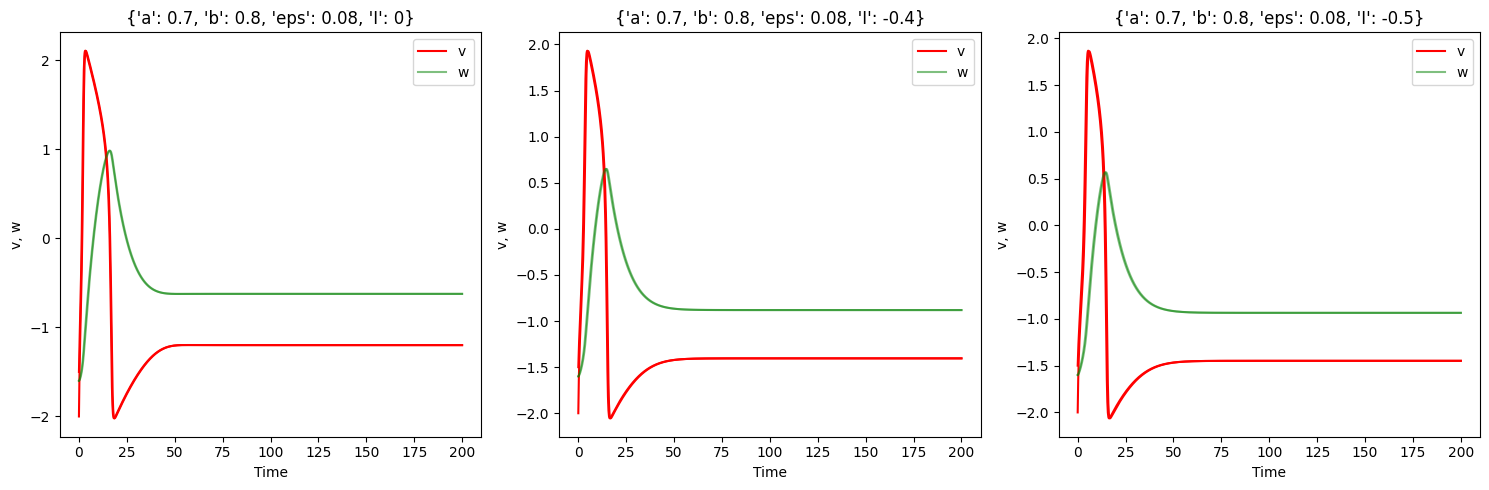

In [548]:
# Do the numerical integration.
trajectories = {} # We store the trajectories in a dictionnary, it is easier to recover them. 
for i,param in enumerate(scenarios):
    trajectories[i] = get_displacement(param, number=2, time_span=time_span, dmax=0.5)

# Draw the trajectories. 
fig, ax = plt.subplots(1, len(scenarios), figsize=(5*len(scenarios),5))
for i,param in enumerate(scenarios):
        ax[i].set(xlabel='Time', ylabel='v, w',
                     title='{}'.format(param))
        for j in range(len(trajectories[i])):
            v = ax[i].plot(time_span,trajectories[i][j][:,0], color='r')
            w = ax[i].plot(time_span,trajectories[i][j][:,1], color='g', alpha=.5)
        ax[i].legend([v[0],w[0]],['v','w'])
plt.tight_layout()

In [484]:
def plot_isocline(ax, a, b, eps, I, color='k', style='-', opacity=.5, vmin=-2,vmax=2):
    """Plot the null iscolines of the Fitzhugh nagumo system"""
    v = np.linspace(vmin,vmax,100)
    ax.plot(v, v - v**3/3 + I, style, color='r', alpha=opacity)
    ax.plot(v, (v + a)/b, style, color='g', alpha=opacity)

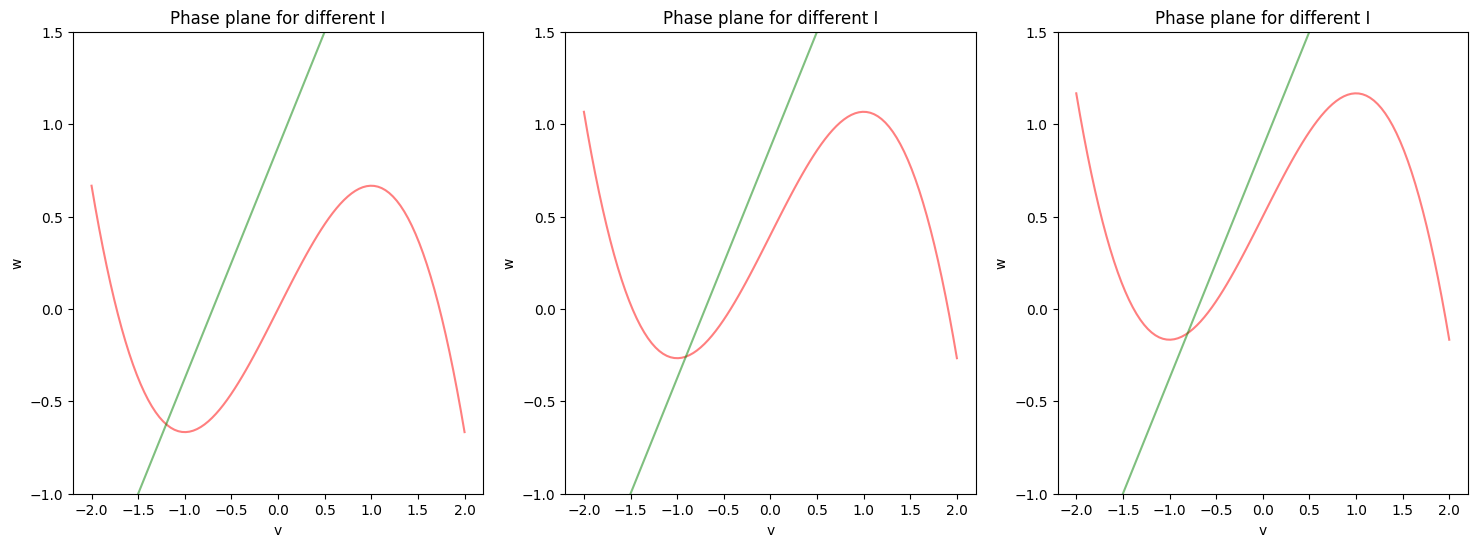

In [486]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i, sc in enumerate(scenarios):
    plot_isocline(ax[i], **sc)
    ax[i].set(xlabel='v', ylabel='w',
              title='Phase plane for different I', ylim=(-1, 1.5))

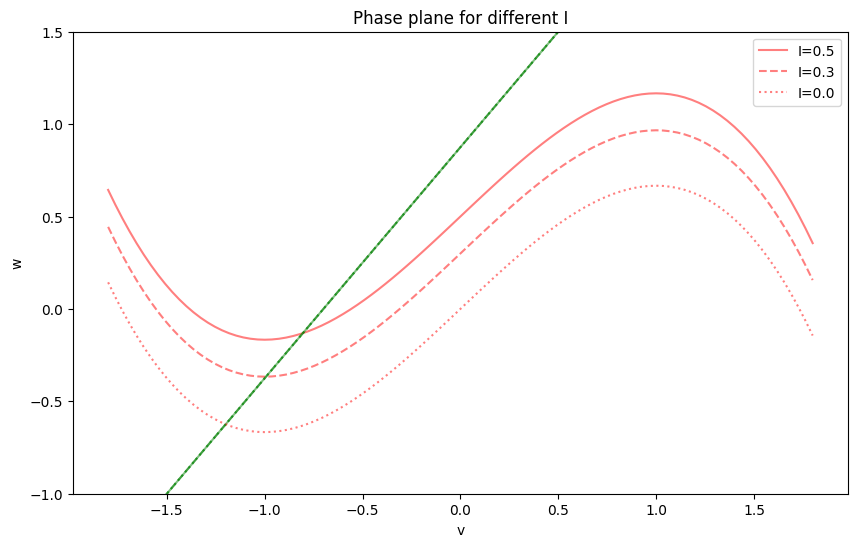

In [50]:
def plot_isocline(ax, a, b, eps, I, color='k', style='-', opacity=0.5, vmin=-1.8, vmax=1.8):
    """Plot the null iscolines of the Fitzhugh-Nagumo system"""
    v = np.linspace(vmin, vmax, 100)
    if style == '-':
        ax.plot(v, v - v**3/3 + I, style, color='r', alpha=opacity, label=f'I={I}')
    elif style == '--':
        ax.plot(v, v - v**3/3 + I, style, color='r', alpha=opacity, label=f'I={I}')
    elif style == ':':
        ax.plot(v, v - v**3/3 + I, style, color='r', alpha=opacity, label=f'I={I}')
    ax.plot(v, (v + a)/b, style, color='g', alpha=opacity)

fig, ax = plt.subplots(figsize=(10, 6))

plot_isocline(ax, **scenarios[0], style='-', opacity=0.5)
plot_isocline(ax, **scenarios[1], style='--', opacity=0.5)
plot_isocline(ax, **scenarios[2], style=':', opacity=0.5)

ax.set(xlabel='v', ylabel='w', title='Phase plane for different I', ylim=(-1, 1.5))
ax.legend()

plt.show()



In [530]:
def plot_vector_field(ax, param, xrange, yrange, steps=50):
    # Compute the vector field
    x = np.linspace(xrange[0], xrange[1], steps)
    y = np.linspace(yrange[0], yrange[1], steps)
    X,Y = np.meshgrid(x,y)
    
    dx,dy = fitzhugh_nagumo([X,Y],0,**param)   
    
    # streamplot is an alternative to quiver 
    # that looks nicer when your vector filed is
    # continuous.
    ax.streamplot(X,Y,dx, dy, color=(0,0,0,.1))
    
    ax.set(xlim=(xrange[0], xrange[1]), ylim=(yrange[0], yrange[1]))

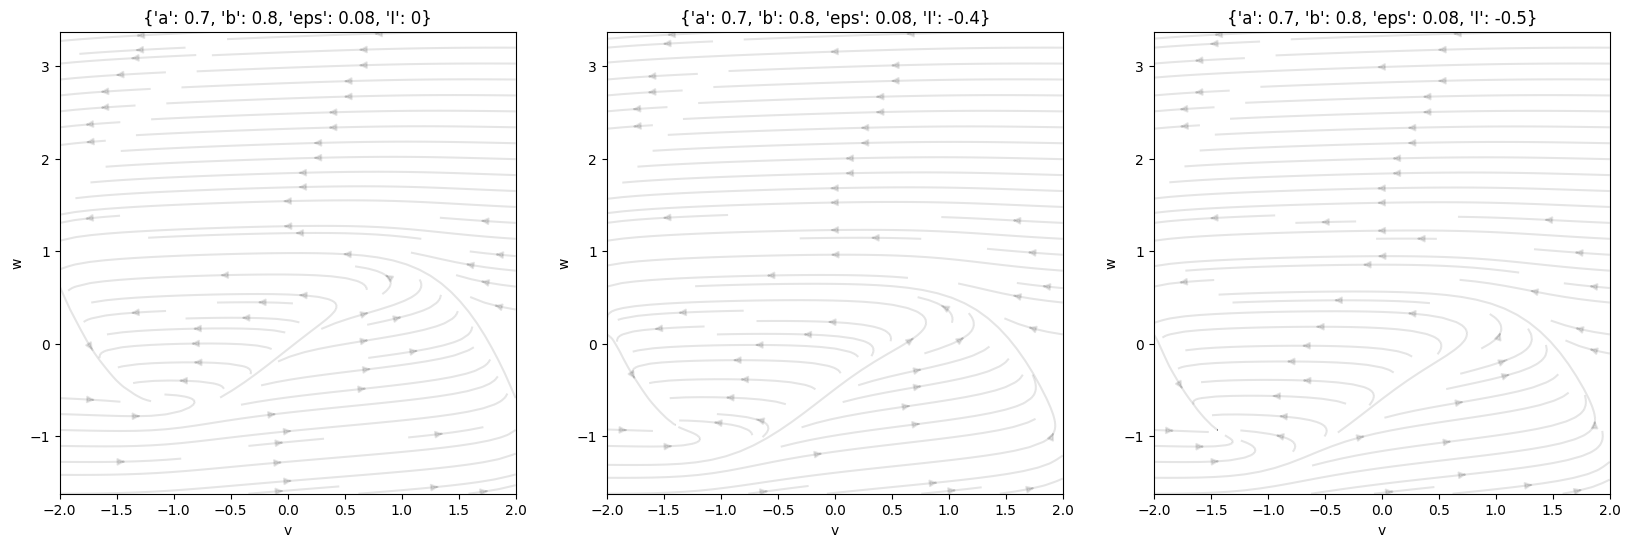

In [531]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
for i, sc in enumerate(scenarios):
    xrange = (-2, 2)
    yrange = [(1/sc['b'])*(x+sc['a']) for x in xrange]
    plot_vector_field(ax[i], sc, xrange, yrange)
    ax[i].set(xlabel='v', ylabel='w',
          title='{}'.format(sc))

In [106]:
def find_roots(a,b,I, eps):
    # The coeficients of the polynomial equation are:
    # 1           * v**3 
    # 0           * v**2 
    # - (1/b - 1) * v**1 
    # - (a/b + I) * v**0
    coef = [1/3, 0, 1/b - 1, a/b - I]
    
    # We are only interested in real roots.
    # np.isreal(x) returns True only if x is real. 
    # The following line filter the list returned by np.roots
    # and only keep the real values. 
    roots = [np.real(r) for r in np.roots(coef) if np.isreal(r)]
    
    # We store the position of the equilibrium. 
    return [[r, r - r**3/3 + I] for r in roots]

eqnproot = {}
for i, param in enumerate(scenarios):
    eqnproot[i] = find_roots(**param)

# Implement the jacobian of the system and use numpy.linalg.eig to determine the local topology of the equilibria. 

# You can use the following color code:
EQUILIBRIUM_COLOR = {'Stable node':'C0',
                    'Unstable node':'C1', 
                    'Saddle':'C4',
                    'Stable focus':'C3',
                    'Unstable focus':'C2',
                    'Center':'C5'}


def jacobian_fitznagumo(v, w, a, b, eps, I):
    """ Jacobian matrix of the ODE system modeling Fitzhugh-Nagumo's excitable system
    Args
    ====
        v (float): Membrane potential
        w (float): Recovery variable
        a,b (float): Parameters
        eps (float): Rverse of recovery timescale.
    Return: np.array 2x2"""
    return np.array([[1-v**2 , -1],
                       [eps, -b*eps]])

In [56]:
# Symbolic computation of the Jacobian using sympy... 
import sympy 
sympy.init_printing()

# Define variable as symbols for sympy
v, w = sympy.symbols("v, w")
a, b, eps, I = sympy.symbols("a, b, eps, I")

# Symbolic expression of the system
dvdt = v - v**3/3 - w + I
dwdt = (v + a - b * w)*eps

# Symbolic expression of the matrix
sys = sympy.Matrix([dvdt, dwdt])
var = sympy.Matrix([v, w])
jac = sys.jacobian(var)

# You can convert jac to a function:
jacobian_fitznagumo_symbolic = sympy.lambdify((v, w, a, b, eps, I), jac, dummify=False)

#jacobian_fitznagumo = jacobian_fitznagumo_symbolic
jac

⎡     2        ⎤
⎢1 - v     -1  ⎥
⎢              ⎥
⎣ eps    -b⋅eps⎦

In [57]:
def stability(jacobian):
    """ Stability of the equilibrium given its associated 2x2 jacobian matrix. 
    Use the eigenvalues. 
    Args:
        jacobian (np.array 2x2): the jacobian matrix at the equilibrium point.
    Return:
        (string) status of equilibrium point.
    """
    
    eigv = np.linalg.eigvals(jacobian)
    
    
    if all(np.real(eigv)==0) and all(np.imag(eigv)!=0):
        nature = "Center" 
    elif np.real(eigv)[0]*np.real(eigv)[1]<0:
        nature = "Saddle"
    else: 
        stability = 'Unstable' if all(np.real(eigv)>0) else 'Stable'
        nature = stability + (' focus' if all(np.imag(eigv)!=0) else ' node')
    return nature

def stability_alt(jacobian):
    """ Stability of the equilibrium given its associated 2x2 jacobian matrix. 
    Use the trace and determinant. 
    Args:
        jacobian (np.array 2x2): the jacobian matrix at the equilibrium point.
    Return:
        (string) status of equilibrium point.
    """
    
    determinant = np.linalg.det(jacobian)
    trace = np.matrix.trace(jacobian)
    if np.isclose(trace, 0):
        nature = "Center (Hopf)"
    elif np.isclose(determinant, 0):
        nature = "Transcritical (Saddle-Node)"
    elif determinant < 0:
        nature = "Saddle"
    else:
        nature = "Stable" if trace < 0 else "Unstable"
        nature += " focus" if (trace**2 - 4 * determinant) < 0 else " node"
    return nature

In [58]:
eqstability = {}
for i, param in enumerate(scenarios):
    eqstability[i] = []
    for e in eqnproot[i]:
        J = jacobian_fitznagumo(e[0],e[1], **param)
        eqstability[i].append(stability(J))    
eqstability

{0: ['Unstable focus'], 1: ['Stable focus'], 2: ['Stable focus']}

In [546]:
def plot_phase_diagram(param, ax=None, title=None):
    """Plot a complete Fitzhugh-Nagumo phase Diagram in ax.
    Including isoclines, flow vector field, equilibria and their stability"""
    if ax is None:
        ax = plt.gca()
    if title is None:
        title = "Phase space, {}".format(param) 
    
    ax.set(xlabel='v', ylabel='w', title=title)
        
    # Isocline and flow... 
    xlimit = (-2.5, 2.5)
    ylimit = (-2, 1)
    plot_vector_field(ax, param, xlimit, ylimit)
    plot_isocline(ax, **param, vmin=xlimit[0],vmax=xlimit[1])
    
    # Plot the equilibria 
    eqnproot = find_roots(**param)
    eqstability = [stability(jacobian_fitznagumo(e[0],e[1], **param)) for e in eqnproot] 
    for e,n in zip(eqnproot,eqstability):
        ax.scatter(*e, color=EQUILIBRIUM_COLOR[n])
        
        # Show a small perturbation of the stable equilibria...
        time_span = np.linspace(0, 200, num=1500)
        if n[:6] == 'Stable':
            for perturb in (0.1, 0.6):
                ic = [e[0]+abs(perturb*e[0]),e[1]]
                traj = scipy.integrate.odeint(partial(fitzhugh_nagumo, **param),
                                                  y0=[-2,-1.5],
                                                  t=time_span)
                ax.plot(traj[:,0], traj[:,1])

    # Legend
    labels = frozenset(eqstability)
    ax.legend([mpatches.Patch(color=EQUILIBRIUM_COLOR[n]) for n in labels], labels, 
           loc='lower right')

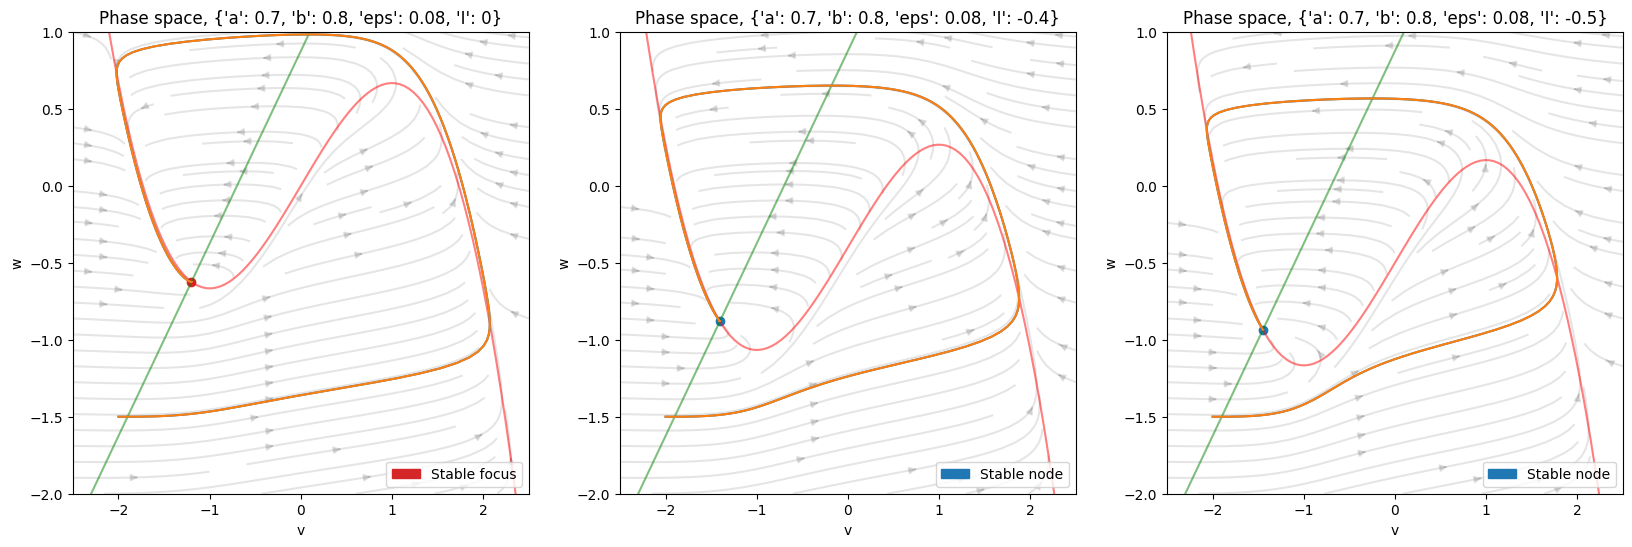

In [547]:
import matplotlib.patches as mpatches #used to write custom legends

fig, ax = plt.subplots(1,3, figsize=(20, 6))
for i, param in enumerate(scenarios):
    plot_phase_diagram(param, ax[i])

In [533]:
# Plot the bifurcation diagram for v with respect to parameter I. 

ispan = np.linspace(-1,2.5,300)
bspan = np.linspace(0.1,2.5,300)

In [534]:
I_list = []
eqs_list = []
nature_legends = []
trace = []
det = []

for I in ispan:
    param = {'I': I, 'a': 0.7, 'b': 0.8, 'eps': 0.08}
    roots = find_roots(**param)
    for v,w in roots:
        J = jacobian_fitznagumo(v,w, **param)
        nature = stability(J)
        nature_legends.append(nature)
        I_list.append(I)
        eqs_list.append(v)
        det.append(np.linalg.det(J))
        trace.append(J[0,0]+J[1,1])

[Text(0.5, 0, 'External stimulus, $I_{ext}$'),
 Text(0, 0.5, 'Equilibrium Membrane potential, $v^*$')]

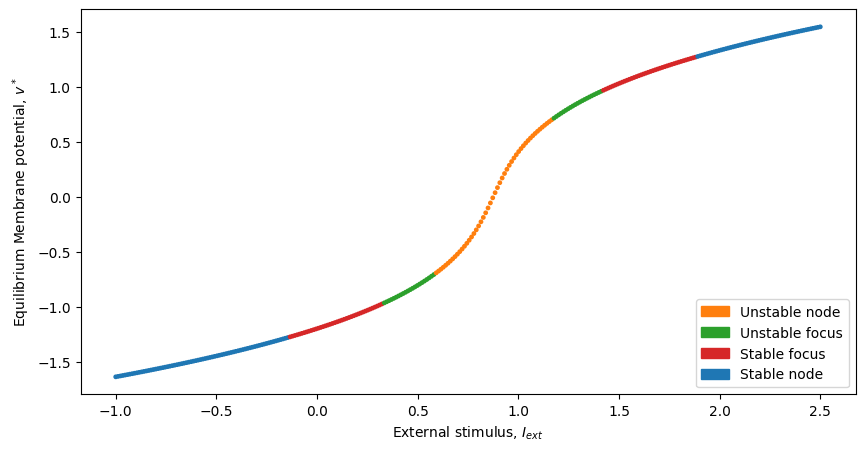

In [535]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
labels = frozenset(nature_legends)
ax.scatter(I_list, eqs_list, c=[EQUILIBRIUM_COLOR[n] for n in nature_legends], s=5.9)  
ax.legend([mpatches.Patch(color=EQUILIBRIUM_COLOR[n]) for n in labels], labels, 
               loc='lower right')
ax.set(xlabel='External stimulus, $I_{ext}$', 
       ylabel='Equilibrium Membrane potential, $v^*$')

Text(0.5, 1.0, "Equilibrium trajectory in the jacobian's Trace/Determinant space")

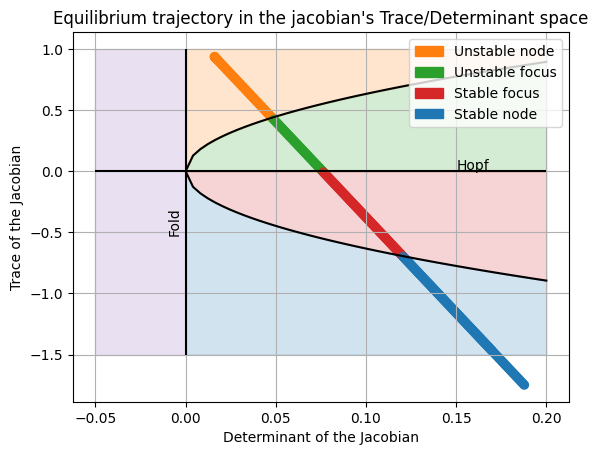

In [536]:
plt.scatter(det,trace, c=[EQUILIBRIUM_COLOR[n] for n in nature_legends])
plt.grid()
x = np.linspace(0,.2)
plt.plot(x, np.sqrt(4*x),color='k')
plt.plot(x, -np.sqrt(4*x),color='k')
plt.vlines(0, -1.5,1, color='k')
plt.hlines(0, -0.05,x.max(), color='k')
plt.text(-0.01, -0.5, 'Fold', rotation=90)
plt.text(0.15, 0.015, 'Hopf')

plt.gca().set(xlabel='Determinant of the Jacobian', ylabel='Trace of the Jacobian')
plt.fill_between(x,0,np.sqrt(4*x), color=EQUILIBRIUM_COLOR['Unstable focus'], alpha=0.2)
plt.fill_between(x,0,-np.sqrt(4*x), color=EQUILIBRIUM_COLOR['Stable focus'], alpha=0.2)
plt.fill_between(x,-np.sqrt(4*x),-1.5, color=EQUILIBRIUM_COLOR['Stable node'], alpha=0.2)
plt.fill_between(x,np.sqrt(4*x),1, color=EQUILIBRIUM_COLOR['Unstable node'], alpha=0.2)
plt.fill_between([-0.05,0],-1.5,1, color=EQUILIBRIUM_COLOR['Saddle'], alpha=0.2)
plt.legend([mpatches.Patch(color=EQUILIBRIUM_COLOR[n]) for n in labels], labels, 
               loc='upper right')
plt.title("Equilibrium trajectory in the jacobian's Trace/Determinant space")

In [520]:
def plot_displacement(param, dmax=0.5, ax1=None, ax2=None, tmax=200, number=1):
    if ax1 is None or ax2 is None:
        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
    # We start from the resting point...
    time_span = np.linspace(0,tmax, 1000)
    ic = scipy.integrate.odeint(partial(fitzhugh_nagumo, **param),
                                                      y0=[0,0.5],
                                                      t=time_span)[-1]

    # and do some displacement of the potential. 
    plot_phase_diagram(param, ax=ax2) 
    for displacement in np.linspace(0,dmax, number):
        traj = scipy.integrate.odeint(partial(fitzhugh_nagumo, **param),
                                                      y0=ic+np.array([displacement,0]),
                                                      t=time_span)
        ax1.plot(time_span, traj[:,0], color='k', alpha=0.3)
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Membrane Potential (v)')
        ax2.plot(traj[:,0], traj[:,1], color='C0')

In [521]:
# Periodic behavior only happen when there are 3 equilibria, on saddle point and two unstable (focus or node). 
roots = []
periodic = []
for x,i in enumerate(ispan):
    roots.append([])
    periodic.append([])
    for y,b in enumerate(bspan):
        param = {'I': i, 'a': 0.7, 'b': b, 'eps': 0.08}
        r = find_roots(**param)
        stab = [stability(jacobian_fitznagumo(v,w, **param)) for v,w in r]
        # Check if none of the equilibria is stable. 
        periodic[x].append(not any([x[:6]=="Stable" for x in stab]))
        roots[x].append([u[0] for u in r])

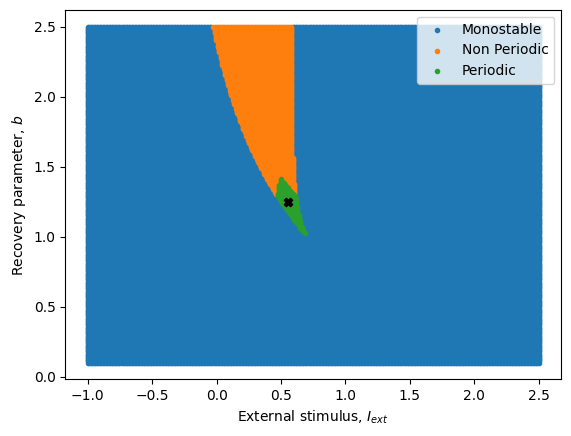

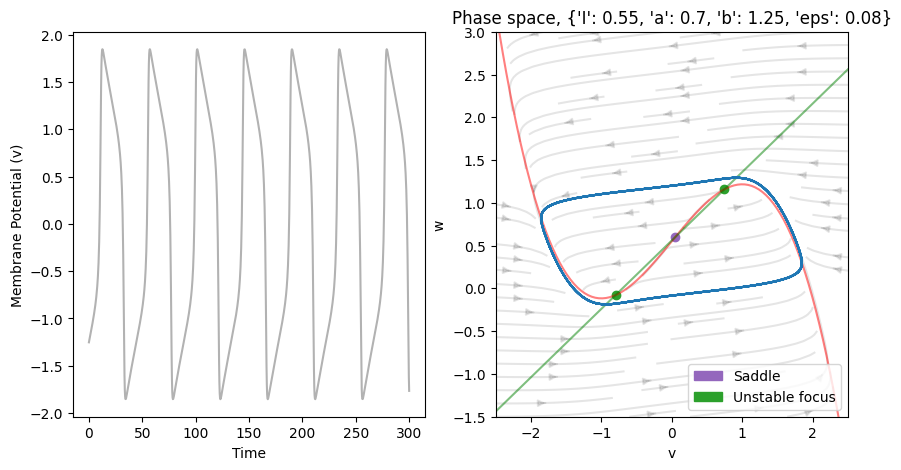

In [522]:
mono = []
bi = []
per = []
for x,i in enumerate(ispan):
    for y,b in enumerate(bspan):
        if len(roots[x][y]) == 1:
            mono.append((i,b))
        else:
            if not periodic[x][y]:
                bi.append((i,b))
            else: 
                per.append((i,b))
plt.scatter(*zip(*mono), color='C0', marker='.' ,label='Monostable')
plt.scatter(*zip(*bi), color='C1', marker='.', label='Non Periodic')
plt.scatter(*zip(*per), color='C2', marker='.', label='Periodic')
plt.legend()


ii = 0.55
bb = 1.25
plt.scatter(ii,bb, marker='X', color='k')

plt.xlabel('External stimulus, $I_{ext}$')
plt.ylabel('Recovery parameter, $b$')
plt.show()
plot_displacement({'I': ii, 'a': 0.7, 'b': bb, 'eps': 0.08}, tmax=300)

**Non autonomous system**

In [552]:
# Implement a non autonomous version of the Fitzhugh Nagumo Model. 
# Simulate some trajectories. 

# Here are a few stimulus function that you can try. 
def step_stimulus(t, value, time):
    """Step stimulus for the non autonomous Fitzhugh-Nagumo model"""
    return 0 if t<time else value

def step_stimulus_2(t, values, time):
    """Step stimulus for the non autonomous Fitzhugh-Nagumo model"""
    return 0 if t<time else values[int(t//time)] if t<len(values)*time else values[-1]


def my_step_stimulus(t, value1, time1, value2, time2):
    """Step stimulus with a rising and falling step."""
    if t < time1:
        return 0
    elif t < time2:
        return value2
    else:
        return value1

def linear_increase_stimulus(t, initial_value, final_value, start_time, end_time):
    """Linearly increasing stimulus for the non-autonomous Fitzhugh-Nagumo model"""
    if t < start_time:
        return 0
    elif t < end_time:
        slope = (final_value - initial_value) / (end_time - start_time)
        return initial_value + slope * (t - start_time)
    else:
        return final_value

def delta_stimulus(I0, t0, delta_t=1e-6):
    """Delta stimulus for the non-autonomous Fitzhugh-Nagumo model"""
    def stimulus_function(t):
        return I0 if abs(t - t0) < delta_t / 2 else 0
    return stimulus_function


def periodic_stimulus(t, magnitude, freq):
    """Periodic stimulus for the non autonomous Fitzhugh-Nagumo model"""
    return magnitude * np.sin(freq * t)

def generate_noisy(scale, steps=300, dt=1, tmax=300):
    time = np.linspace(0, tmax, num=steps)
    noise = [0]
    for i in range(len(time)-1):
        noise.append( noise[-1] + (0-noise[-1])*dt + dt*np.random.normal(loc=0, scale=scale))
    def noisy_stimulus(t):
        """Noisy stimulus for the non autonomous Fitzhugh-Nagumo model"""
        tscaled = (t/tmax)*(len(noise)-2)
        i = int(tscaled)
        return (tscaled-i)*noise[i] + (i+1-tscaled)*noise[1+i]
    return noisy_stimulus

# Some parameter sets:
step_sc = []
time_span = np.linspace(0, 500, num=1000)

step_sc.append({"a":.7, "b":.8, "eps":0.077, 'I': partial(step_stimulus, value=-0.5, time=100)})   
step_sc.append({"a": 0.7, "b": 0.8, "eps": 0.077, 'I': partial(my_step_stimulus, value1=0, time1=100, value2=0.2, time2=111)})
step_sc.append({"a":.7, "b":.8, "eps":0.077, 'I': partial(step_stimulus_2, values=[0,0.32,0.5], time=100)})
step_sc.append({"a":.7, "b":.8, "eps":0.077, 'I': partial(periodic_stimulus, magnitude=0.19,freq=.1)})
# step_sc.append({"a":.7, "b":.8, "eps":0.077, 'I': generate_noisy(.5, tmax=time_span[-1], steps=len(time_span))})
#step_sc.append({"a":.7, "b":.8, "eps":0.077, 'I': partial(linear_increase_stimulus, initial_value = 0, final_value=1, start_time = 0, end_time=500)})   
step_sc.append({"a":.7, "b":.8, "eps":0.077, 'I': partial(step_stimulus, value=0.5, time=100)})   




'''step_sc.append({"a":1.05, "b":0, "eps":0.01, "D" : 0.04 , 'I': generate_noisy(1, tmax=time_span[-1], steps=len(time_span))})
step_sc.append({"a":1.05, "b":0, "eps":0.01, "D" : 0.07 , 'I': generate_noisy(1, tmax=time_span[-1], steps=len(time_span))})
step_sc.append({"a":1.05, "b":0, "eps":0.01, "D" : 0.4 , 'I': generate_noisy(1, tmax=time_span[-1], steps=len(time_span))})
step_sc.append({"a":1.05, "b":0, "eps":0.01, "D" : 0.8 , 'I': generate_noisy(1, tmax=time_span[-1], steps=len(time_span))})
step_sc.append({"a":1.05, "b":0, "eps":0.01, "D" : 1.2 , 'I': generate_noisy(1, tmax=time_span[-1], steps=len(time_span))})
step_sc.append({"a":1.05, "b":0, "eps":0.01, "D" : 2 , 'I': generate_noisy(1, tmax=time_span[-1], steps=len(time_span))})
'''



'step_sc.append({"a":1.05, "b":0, "eps":0.01, "D" : 0.04 , \'I\': generate_noisy(1, tmax=time_span[-1], steps=len(time_span))})\nstep_sc.append({"a":1.05, "b":0, "eps":0.01, "D" : 0.07 , \'I\': generate_noisy(1, tmax=time_span[-1], steps=len(time_span))})\nstep_sc.append({"a":1.05, "b":0, "eps":0.01, "D" : 0.4 , \'I\': generate_noisy(1, tmax=time_span[-1], steps=len(time_span))})\nstep_sc.append({"a":1.05, "b":0, "eps":0.01, "D" : 0.8 , \'I\': generate_noisy(1, tmax=time_span[-1], steps=len(time_span))})\nstep_sc.append({"a":1.05, "b":0, "eps":0.01, "D" : 1.2 , \'I\': generate_noisy(1, tmax=time_span[-1], steps=len(time_span))})\nstep_sc.append({"a":1.05, "b":0, "eps":0.01, "D" : 2 , \'I\': generate_noisy(1, tmax=time_span[-1], steps=len(time_span))})\n'

In [553]:

#da rivedere
initial_conditions = [(-0.78,-0.1), [0, 0.875]]

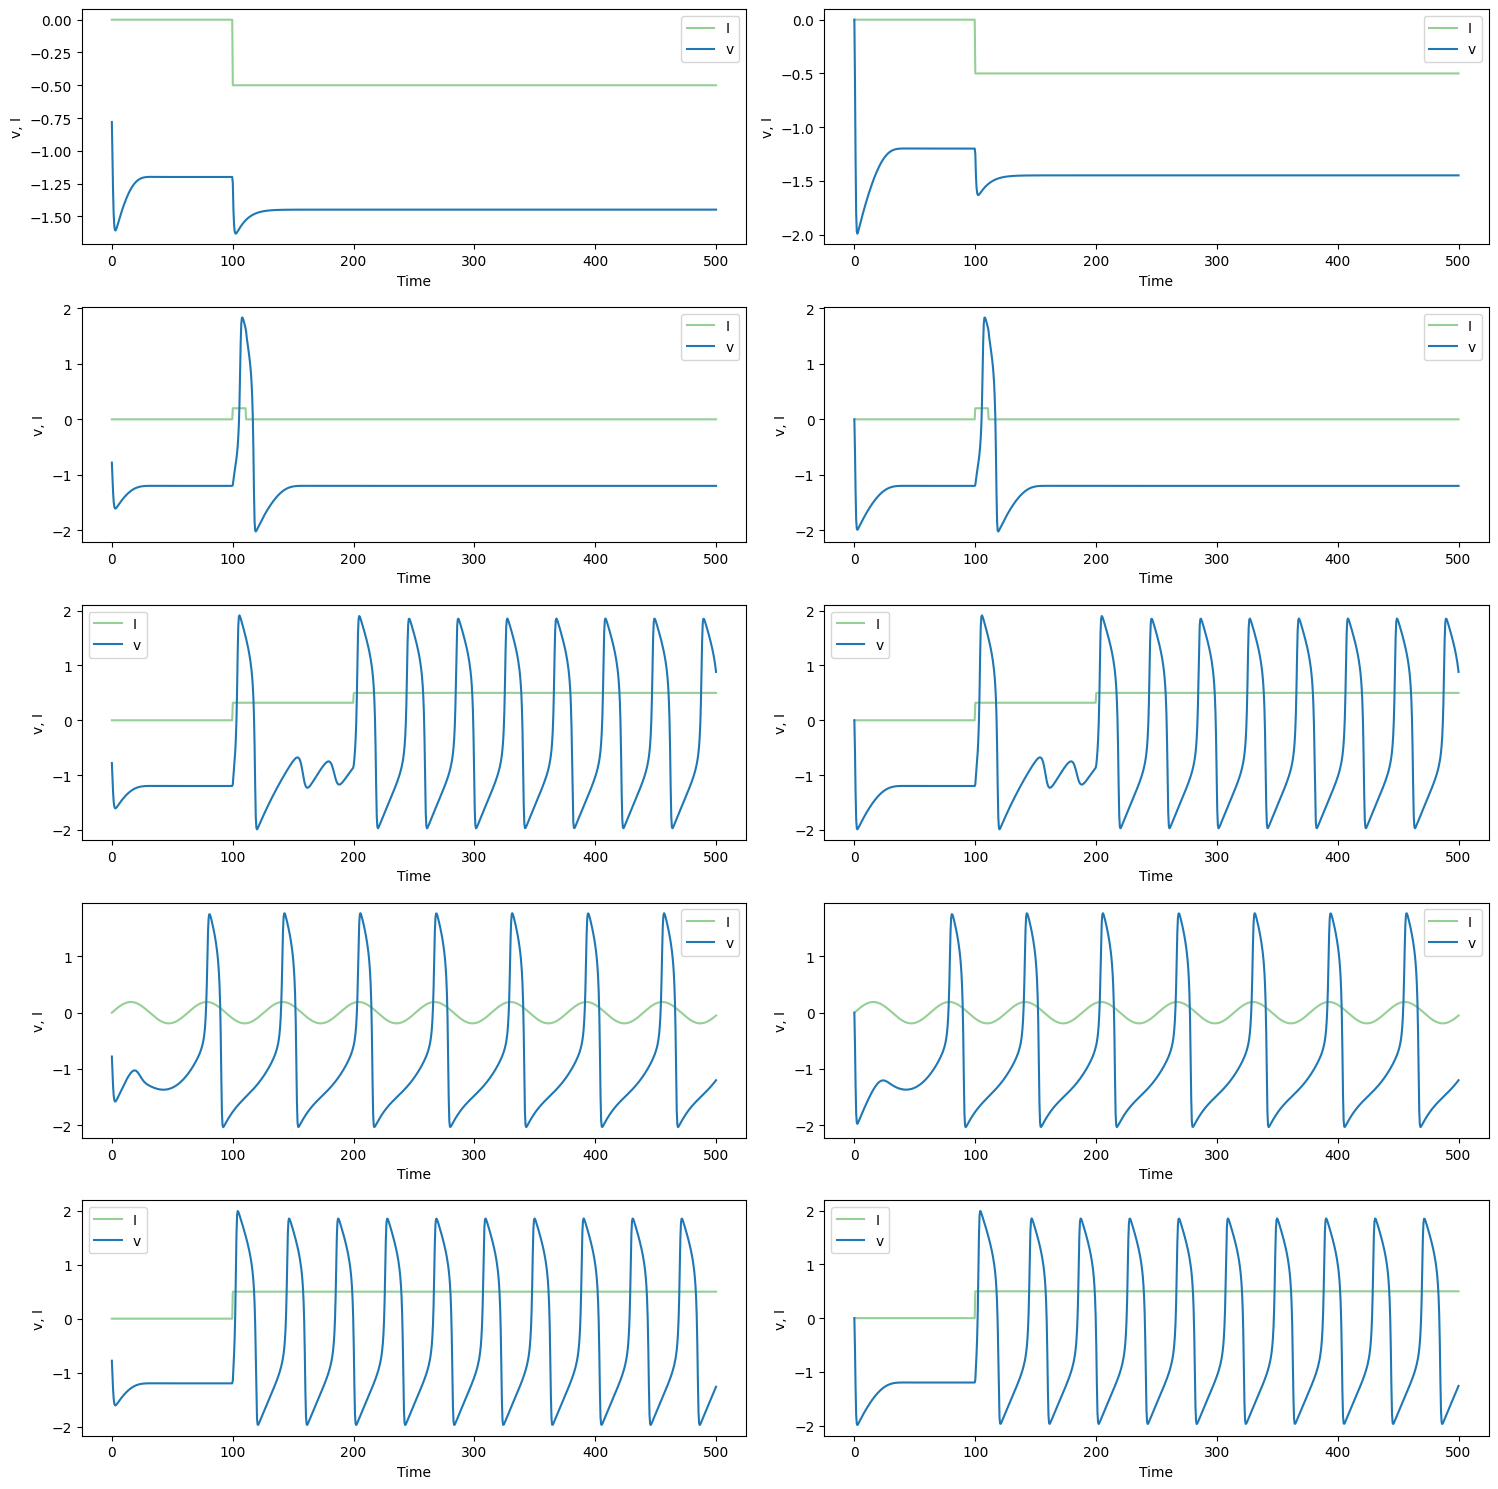

In [554]:
def non_autonomous_fitzhugh_nagumo(x, t, a, b, eps, I):
    """Time derivative of the Fitzhugh-Nagumo neural model.
    Args:
       x (array size 2): [Membrane potential, Recovery variable]
       a, b (float): Parameters.
       tau (float): Time scale.
       t (float): Time (Not used: autonomous system)
       I (function of t): Stimulus current. 
    Return: dx/dt (array size 2)
    """
    return np.array([x[0] - x[0]**3/3 - x[1] + I(t), 
                     (x[0] + a - b * x[1])*eps])
trajectory_nonauto = {} 
for i, param in enumerate(step_sc):
    flow = partial(non_autonomous_fitzhugh_nagumo, **param)
    for j, ic in enumerate(initial_conditions):
        trajectory_nonauto[i, j] = scipy.integrate.odeint(flow,
                                                          y0=ic,
                                                          t=time_span)
# Draw the trajectories. 
fig, ax = plt.subplots(len(step_sc), 2, figsize=(15,15))
for i, param in enumerate(step_sc):
    for j, ic in enumerate(initial_conditions):
        ax[i, j].set(xlabel='Time', ylabel='v, I')
        ax[i, j].plot(time_span,[param['I'](t) for t in time_span], label='I', color='C2', alpha=0.5)
        ax[i, j].plot(time_span,trajectory_nonauto[i, j][:,0], label='v', color='C0')
        ax[i, j].legend()
plt.tight_layout()

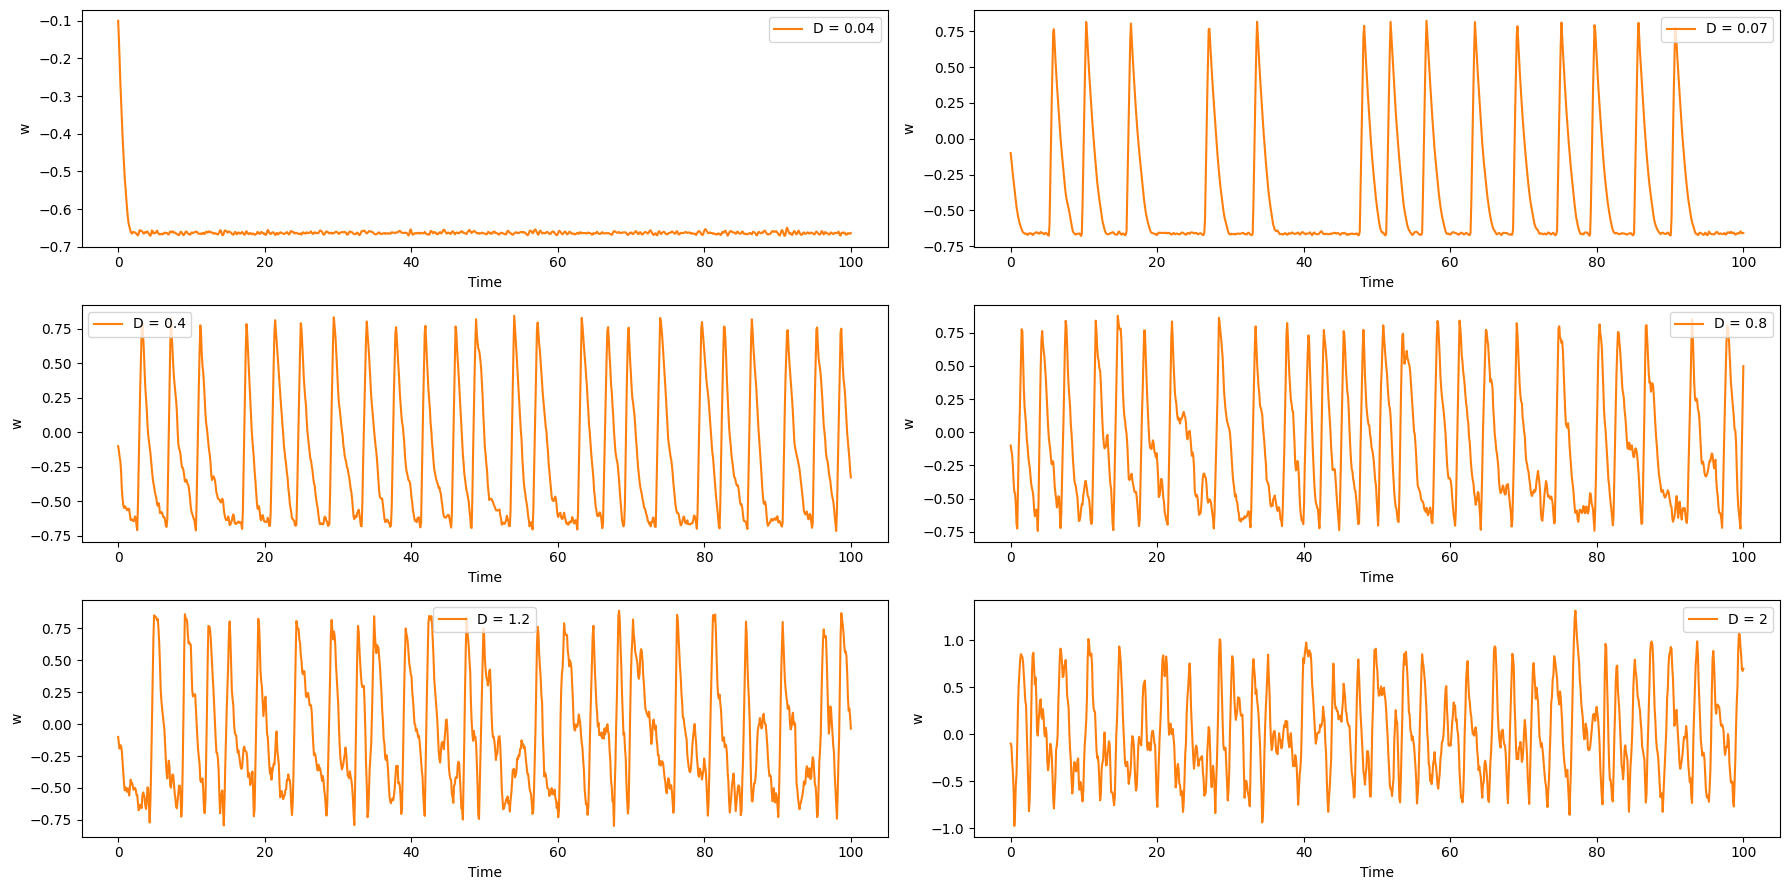

In [273]:
# Draw the trajectories in two columns. 
fig, ax = plt.subplots(len(step_sc)//2, 2, figsize=(18, 3*len(step_sc)//2))
for i, param in enumerate(step_sc):
    row = i // 2
    col = i % 2
    ax[row, col].set(xlabel='Time', ylabel='w')
    ax[row, col].plot(time_span, trajectory_nonauto[i, 0][:, 1], label=f'D = {param["D"]}', color='C1')
    ax[row, col].legend()
plt.tight_layout()


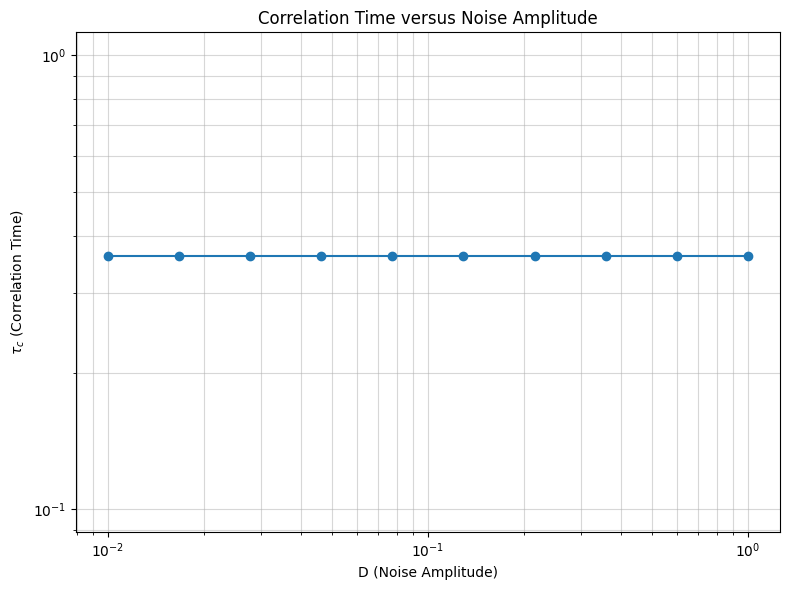

In [283]:
# Function to compute the autocorrelation of a given data series
def autocorrelation(data):
    mean = np.mean(data)
    centered_data = data - mean
    autocorr = np.correlate(centered_data, centered_data, mode='full')
    autocorr /= autocorr[len(data) - 1]  # Normalize the autocorrelation values
    return autocorr[len(data) - 1:]

# Function to calculate the time of correlation (tau_c) using numerical approximation
def correlation_time(data, dt):
    autocorr_values = autocorrelation(data)
    tau_c = dt * np.sum(autocorr_values**2)
    return tau_c

# Compute tau_c for different values of D
D_values = np.logspace(-2, 0, num=10)  # D values from 0.01 to 1
tau_c_values = []

for D_val in D_values:
    # Simulate the FHN model with the current D value and get the w data
    w_data = trajectory_nonauto[0, 0][:, 1]  # Using the first D value here for simplicity
    tau_c = correlation_time(w_data, dt=time_span[1] - time_span[0])
    tau_c_values.append(tau_c)

# Plot tau_c versus D in log-log scale
plt.figure(figsize=(8, 6))
plt.loglog(D_values, tau_c_values, marker='o', linestyle='-', color='C0')
plt.xlabel('D (Noise Amplitude)')
plt.ylabel(r'$\tau_c$ (Correlation Time)')
plt.title('Correlation Time versus Noise Amplitude')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.tight_layout()
plt.show()


In [494]:
def white_noise_flow(y, t, sigma=0.1):
    return np.random.normal(loc=0, scale=sigma)


In [ ]:
def euler_maruyama(flow, noise_flow, y0, t) :
    ''' Euler-Maruyama intergration.
    
    Args:
        flow (function): deterministic component of the flow (f(Yt,t))
        noise_flow (function): stochastic component of the flow (g(Yt,t))
        y0 (np.array): initial condition
        t (np.array): time points to integrate. 
        
    Return the Euler Maruyama approximation of the SDE trajectory defined by:
    
    y(t) = f(Y(t),t)dt + g(Yt,t)dBt
    y(0) = y0 
    '''
    y = np.zeros((len(t),len(y0)))
    y[0] = y0
    for n,dt in enumerate(np.diff(t),1):
        y[n] = y[n-1] + flow(y[n-1],dt) * dt + noise_flow(y[n-1],dt) * np.random.normal(0,np.sqrt(dt))
    return y

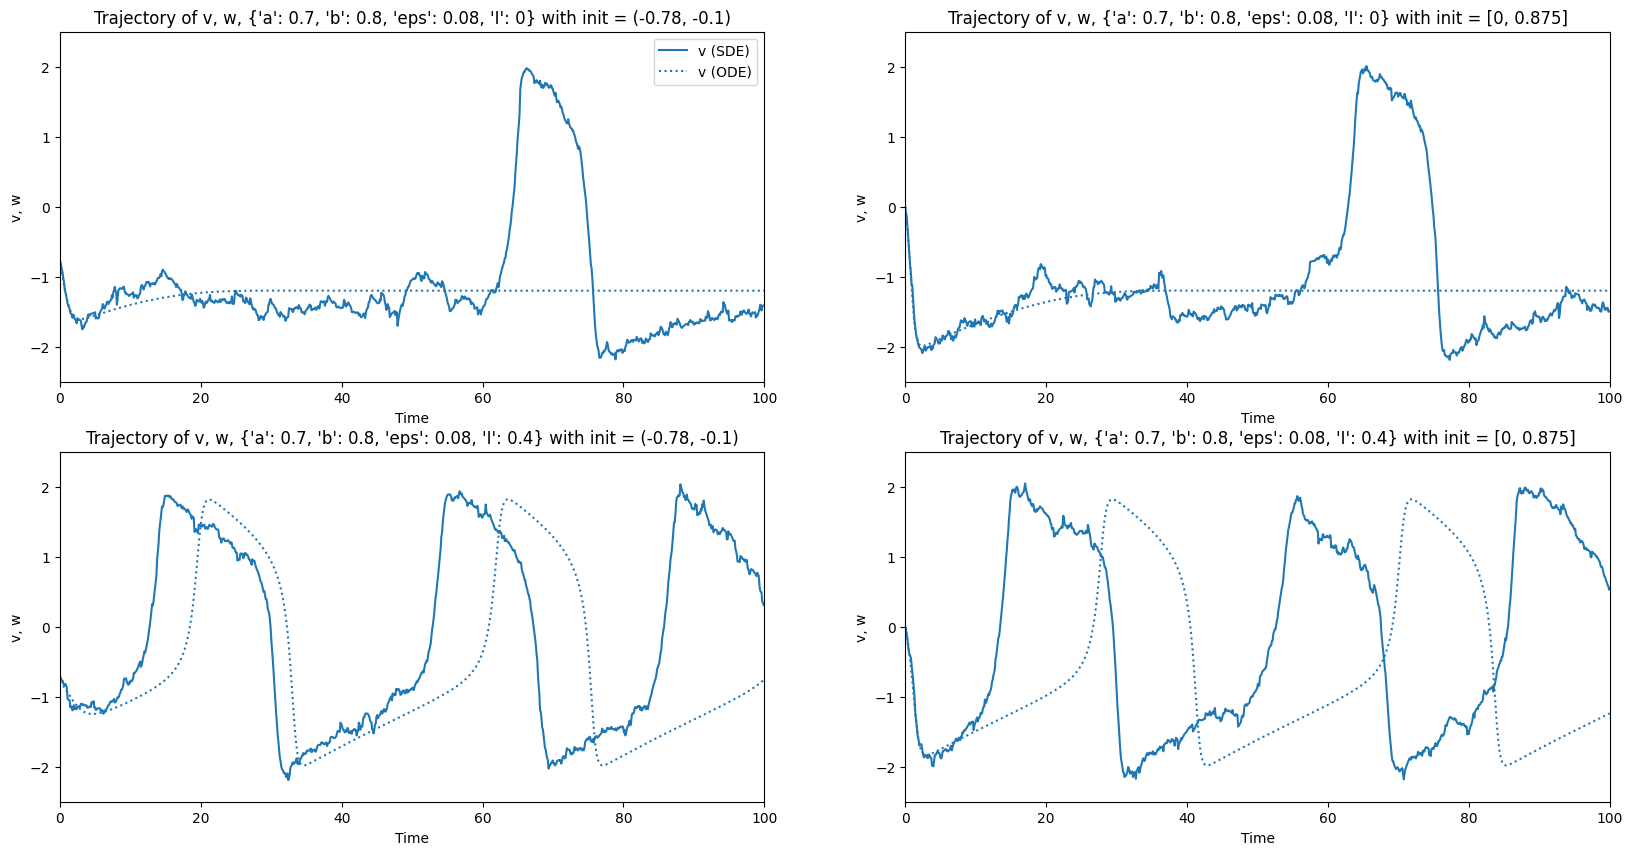

In [506]:


# Do the simulations.
# Remember that we define f as the partial application of fitzhugh_nagumo.
time_s = np.linspace(0, 100, num=1000)
stochastic = {}
trajectory = {}
noise_flow = lambda y,t: 0.04

for i,param in enumerate(scenarios[:2]):
    for j, ic in enumerate(initial_conditions):
        # i is key and j is value in the trajectory dictionary
        flow = partial(fitzhugh_nagumo, **param)
        stochastic[i, j] = euler_maruyama(flow,
                                          white_noise_flow,
                                          y0=ic,
                                          t=time_s)
        trajectory[i,j] = scipy.integrate.odeint(flow, y0=ic, t=time_s)
# Draw the trajectories. 
fig, ax = plt.subplots(2, 2, figsize=(20,10))
for i,param in enumerate(scenarios[:2]):
    for j, ic in enumerate(initial_conditions):
        ax[i, j].set(xlabel='Time', ylabel='v, w', title='Trajectory of v, w, {} with init = {}'.format(param, ic),
                    xlim=(0, time_s[-1]), ylim=(-2.5, 2.5))
        ax[i, j].plot(time_s,stochastic[i, j][:,0], label='v (SDE)')
        ax[i, j].plot(time_s,trajectory[i, j][:,0], label='v (ODE)', color='C0', ls=":")
ax[0, 0].legend()

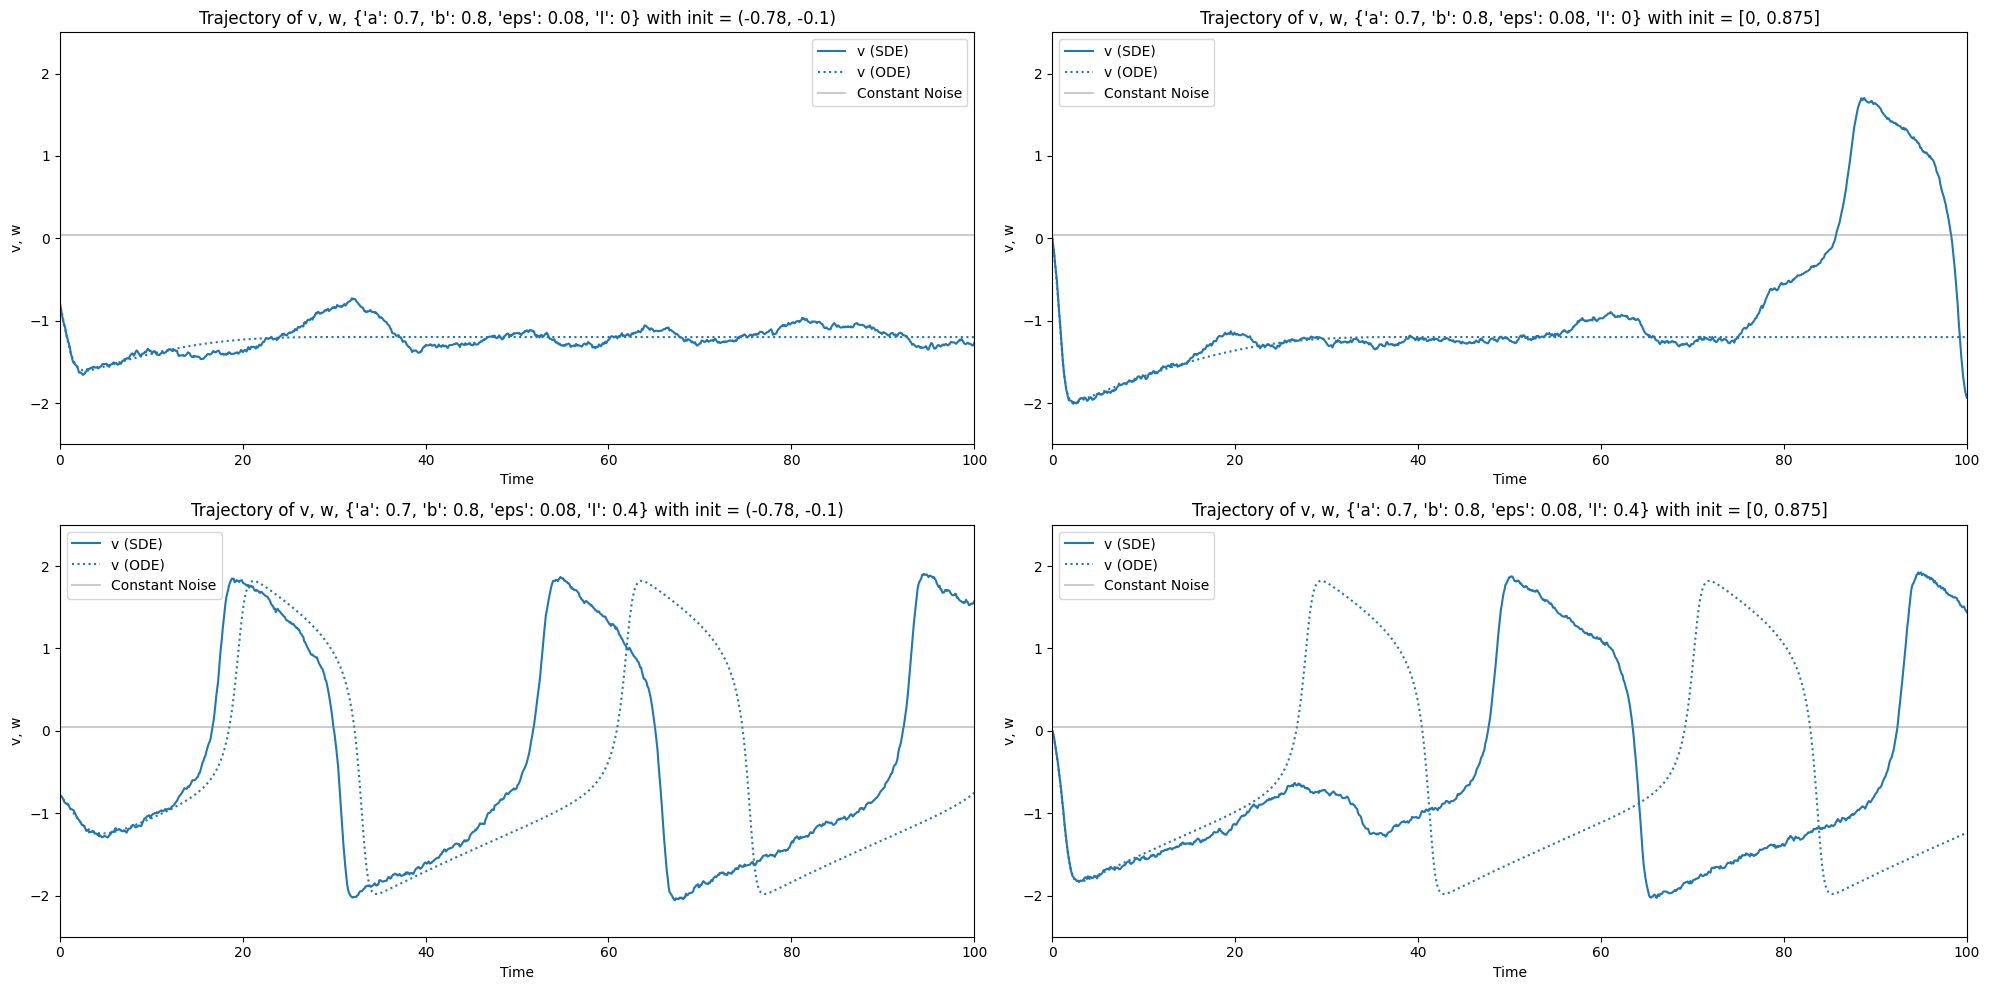

In [507]:
# Define the constant noise flow
noise_flow = lambda y, t: 0.04

# Do the simulations.
# Remember that we define f as the partial application of fitzhugh_nagumo.
time_s = np.linspace(0, 100, num=1000)
stochastic = {}
trajectory = {}
for i, param in enumerate(scenarios[:2]):
    for j, ic in enumerate(initial_conditions):
        # i is key and j is value in the trajectory dictionary
        flow = partial(fitzhugh_nagumo, **param)
        stochastic[i, j] = euler_maruyama(flow,
                                          noise_flow,
                                          y0=ic,
                                          t=time_s)
        trajectory[i, j] = scipy.integrate.odeint(flow, y0=ic, t=time_s)

# Draw the trajectories with constant noise.
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
for i, param in enumerate(scenarios[:2]):
    for j, ic in enumerate(initial_conditions):
        ax[i, j].set(xlabel='Time', ylabel='v, w', title='Trajectory of v, w, {} with init = {}'.format(param, ic),
                     xlim=(0, time_s[-1]), ylim=(-2.5, 2.5))
        ax[i, j].plot(time_s, stochastic[i, j][:, 0], label='v (SDE)')
        ax[i, j].plot(time_s, trajectory[i, j][:, 0], label='v (ODE)', color='C0', ls=":")

        # Plot constant noise
        ax[i, j].plot(time_s, np.full_like(time_s, noise_flow(0, 0)), label='Constant Noise', alpha=0.4, color='gray')

        ax[i, j].legend()

plt.tight_layout()
plt.show()


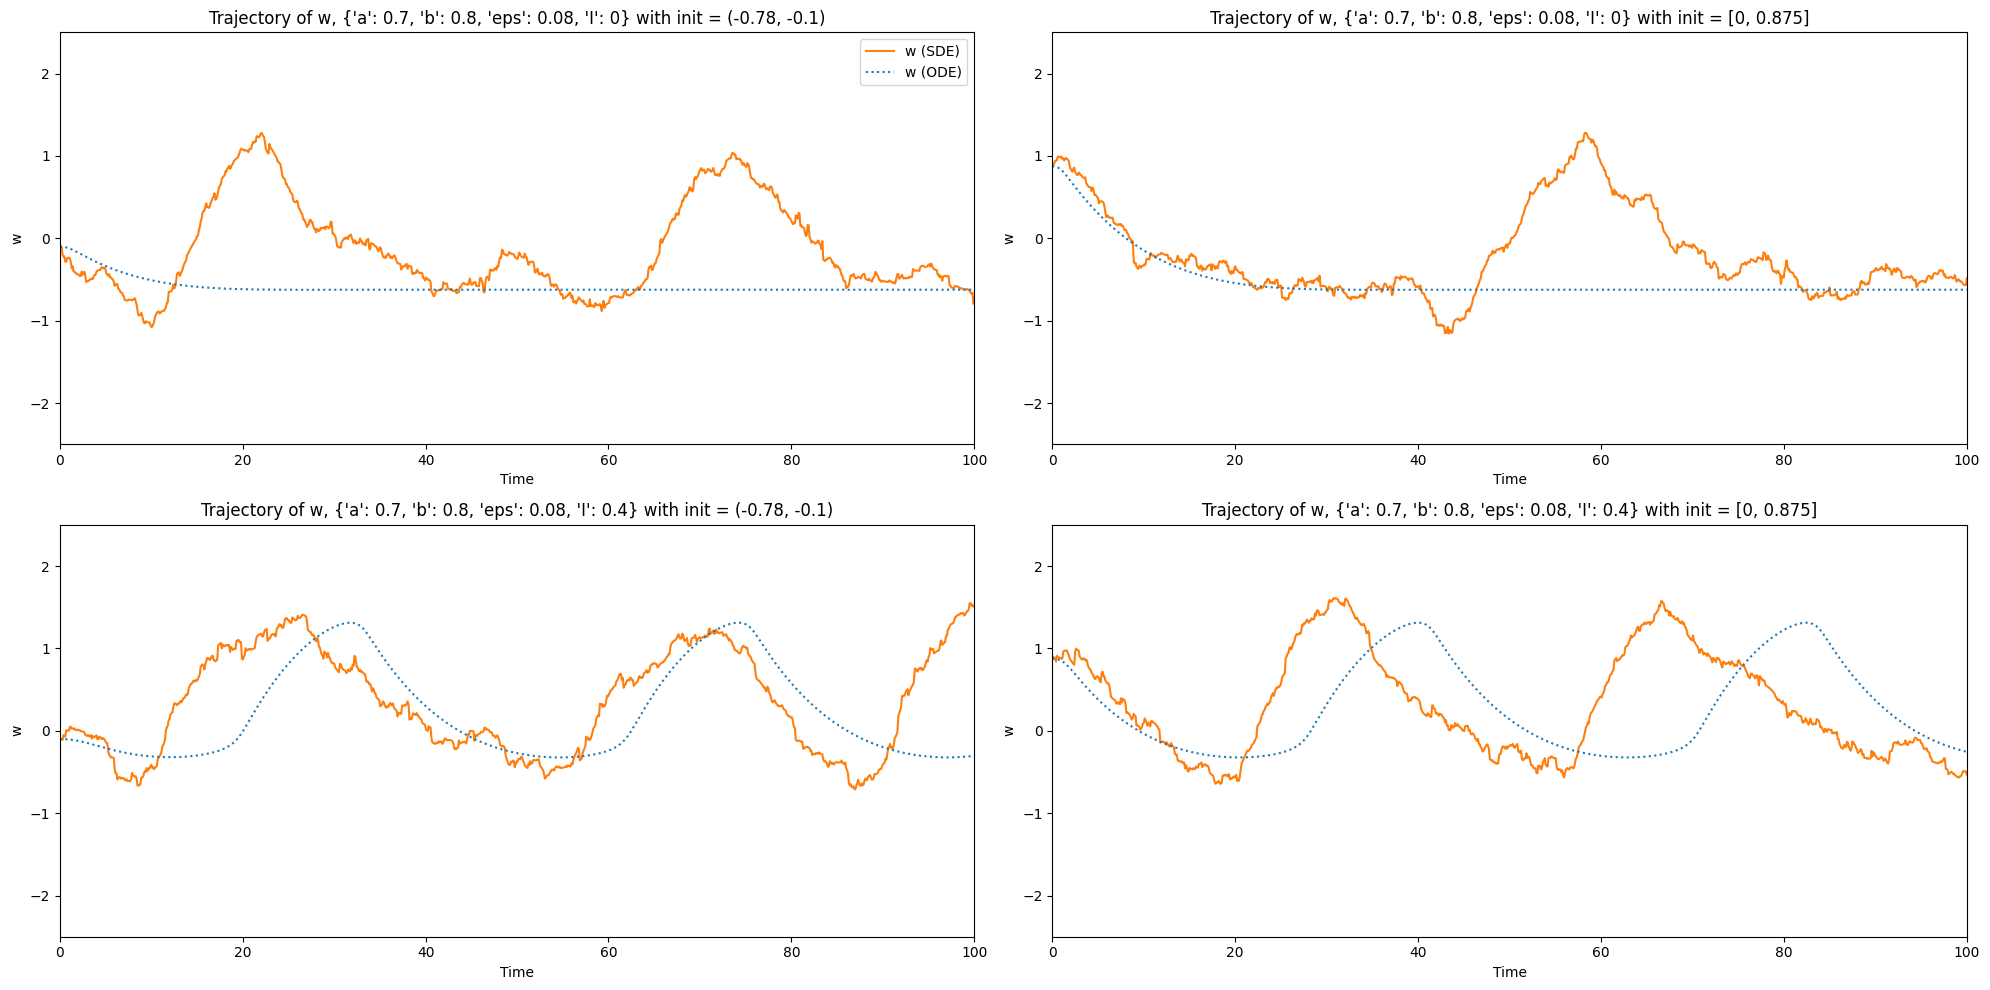

In [508]:
# Do the simulations.
# Remember that we define f as the partial application of fitzhugh_nagumo.
time_s = np.linspace(0, 100, num=1000)
stochastic = {}
trajectory = {}
for i,param in enumerate(scenarios[:2]):
    for j, ic in enumerate(initial_conditions):
        # i is key and j is value in the trajectory dictionary
        flow = partial(fitzhugh_nagumo, **param)
        stochastic[i, j] = euler_maruyama(flow,
                                          white_noise_flow,
                                          y0=ic,
                                          t=time_s)
        trajectory[i,j] = scipy.integrate.odeint(flow, y0=ic, t=time_s)
# Draw the trajectories. 
fig, ax = plt.subplots(2, 2, figsize=(20,10))
for i,param in enumerate(scenarios[:2]):
    for j, ic in enumerate(initial_conditions):
        ax[i, j].set(xlabel='Time', ylabel='w', title='Trajectory of w, {} with init = {}'.format(param, ic),
                    xlim=(0, time_s[-1]), ylim=(-2.5, 2.5))
        ax[i, j].plot(time_s, stochastic[i, j][:, 1], label='w (SDE)', color='C1')
        ax[i, j].plot(time_s, trajectory[i, j][:, 1], label='w (ODE)', color='C0', ls=":")
ax[0, 0].legend()

plt.tight_layout()
plt.show()


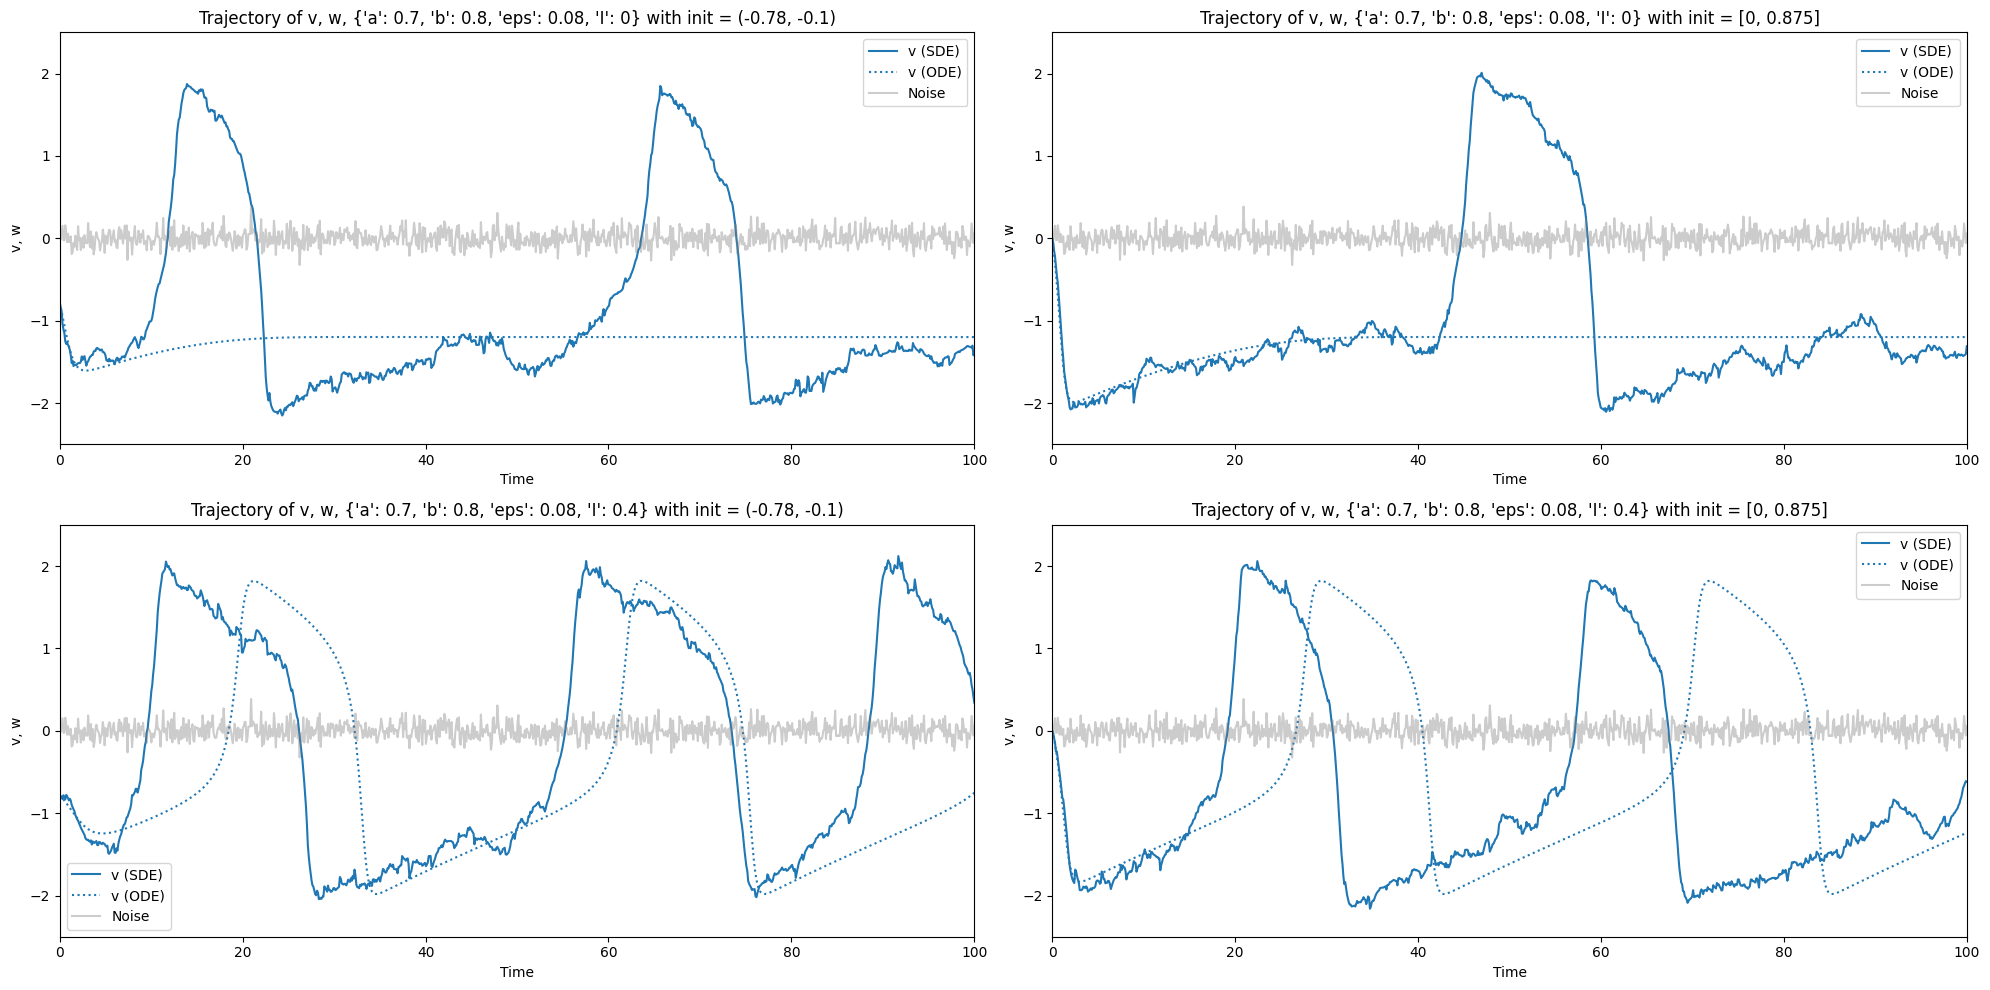

In [509]:
# Draw the trajectories with noise.
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
for i, param in enumerate(scenarios[:2]):
    for j, ic in enumerate(initial_conditions):
        ax[i, j].set(xlabel='Time', ylabel='v, w', title='Trajectory of v, w, {} with init = {}'.format(param, ic),
                     xlim=(0, time_s[-1]), ylim=(-2.5, 2.5))
        ax[i, j].plot(time_s, stochastic[i, j][:, 0], label='v (SDE)')
        ax[i, j].plot(time_s, trajectory[i, j][:, 0], label='v (ODE)', color='C0', ls=":")

        # Generate and plot noise trajectory
        np.random.seed(42)  # Set a seed for reproducibility
        noise_traj = np.array([white_noise_flow(0, 1, sigma=0.1) for t in time_s])
        ax[i, j].plot(time_s, noise_traj, label='Noise', alpha=0.4, color='gray')

        ax[i, j].legend()

plt.tight_layout()
plt.show()



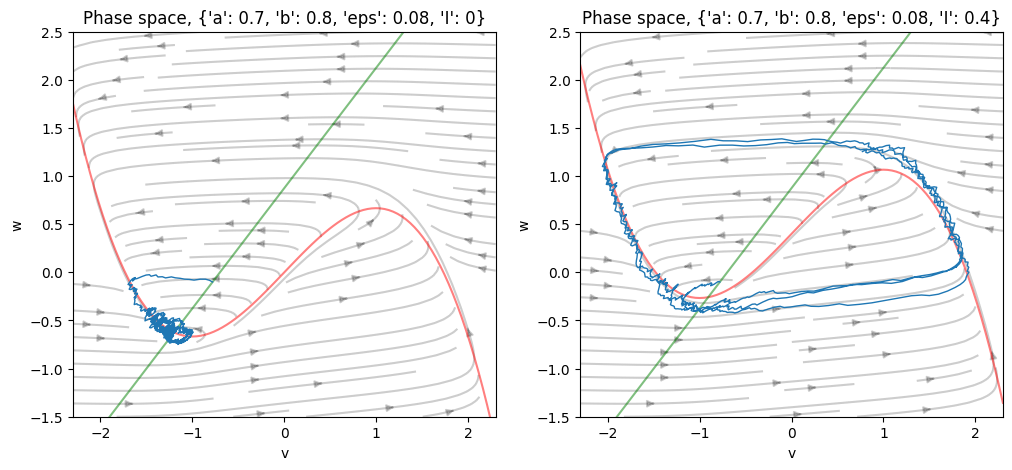

In [505]:
xlimit = (-2.3, 2.3)
ylimit = (-1.5, 2.5)
fig, ax = plt.subplots(1,2, figsize=(12,5))
for i, param in enumerate(scenarios[:2]):
    ax[i].set(xlabel='v', ylabel='w', title="Phase space, {}".format(param))
    plot_vector_field(ax[i], param, xlimit, ylimit)
    plot_vector_field(ax[i], param, xlimit, ylimit)
    plot_isocline(ax[i], **param, vmin=xlimit[0], vmax=xlimit[1])    
    #for j, ic in enumerate(initial_conditions):
    ax[i].plot(stochastic[i, 0][:,0], stochastic[i, 0][:,1],lw=1)

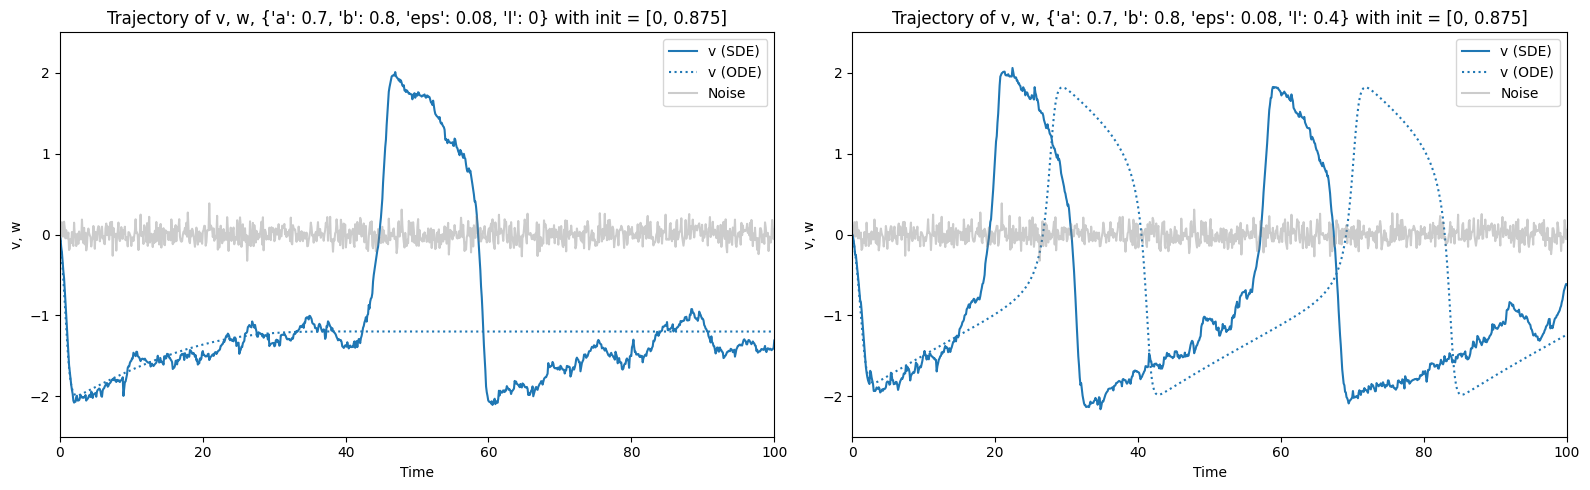

In [510]:
# Draw the trajectories with noise (only second column).
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
for i, param in enumerate(scenarios[:2]):
    for j, ic in enumerate(initial_conditions):
        if j == 1:  # Plot only the second initial condition
            ax[i].set(xlabel='Time', ylabel='v, w', title='Trajectory of v, w, {} with init = {}'.format(param, ic),
                      xlim=(0, time_s[-1]), ylim=(-2.5, 2.5))
            ax[i].plot(time_s, stochastic[i, j][:, 0], label='v (SDE)')
            ax[i].plot(time_s, trajectory[i, j][:, 0], label='v (ODE)', color='C0', ls=":")

            # Generate and plot noise trajectory
            np.random.seed(42)  # Set a seed for reproducibility
            noise_traj = np.array([white_noise_flow(0, 1, sigma=0.1) for t in time_s])
            ax[i].plot(time_s, noise_traj, label='Noise', alpha=0.4, color='gray')

            ax[i].legend()

plt.tight_layout()
plt.show()


Time of the first spike (T): 62.86
Time of the first spike (T): 13.51


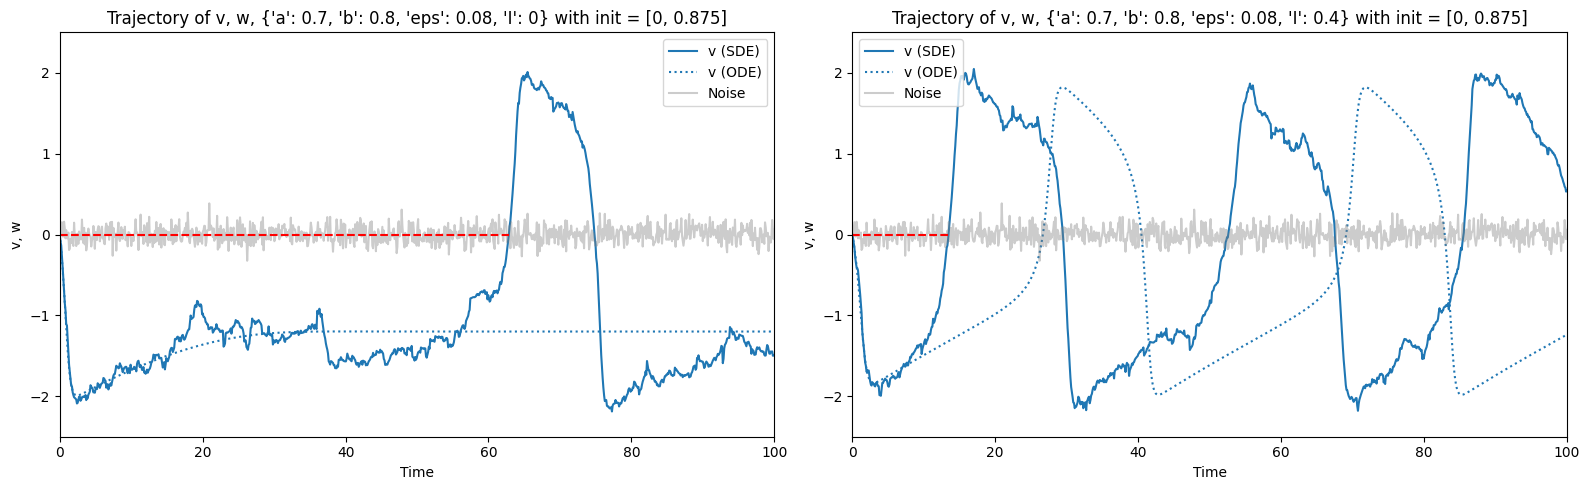

In [517]:
# Draw the trajectories with noise (only second column).
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
for i, param in enumerate(scenarios[:2]):
    for j, ic in enumerate(initial_conditions):
        if j == 1:  # Plot only the second initial condition
            ax[i].set(xlabel='Time', ylabel='v, w', title='Trajectory of v, w, {} with init = {}'.format(param, ic),
                      xlim=(0, time_s[-1]), ylim=(-2.5, 2.5))
            ax[i].plot(time_s, stochastic[i, j][:, 0], label='v (SDE)')
            ax[i].plot(time_s, trajectory[i, j][:, 0], label='v (ODE)', color='C0', ls=":")

            # Generate and plot noise trajectory
            np.random.seed(42)  # Set a seed for reproducibility
            noise_traj = np.array([white_noise_flow(0, 1, sigma=0.1) for t in time_s])
            ax[i].plot(time_s, noise_traj, label='Noise', alpha=0.4, color='gray')

            # Find the time of the first spike (time when v exceeds 0)
            first_spike_time = time_s[np.argmax(stochastic[i, j][:, 0] > 0)]

            # Plot the red dashed line segment from 0 to the first spike time
            ax[i].plot([0, first_spike_time], [0, 0], color='red', linestyle='dashed')

            ax[i].legend()
            # Print the value of T
            print(f"Time of the first spike (T): {first_spike_time:.2f}")
            



plt.tight_layout()
plt.show()


Time of the first spike (T_i): 62.86
Time of the first spike (T_i): 13.51


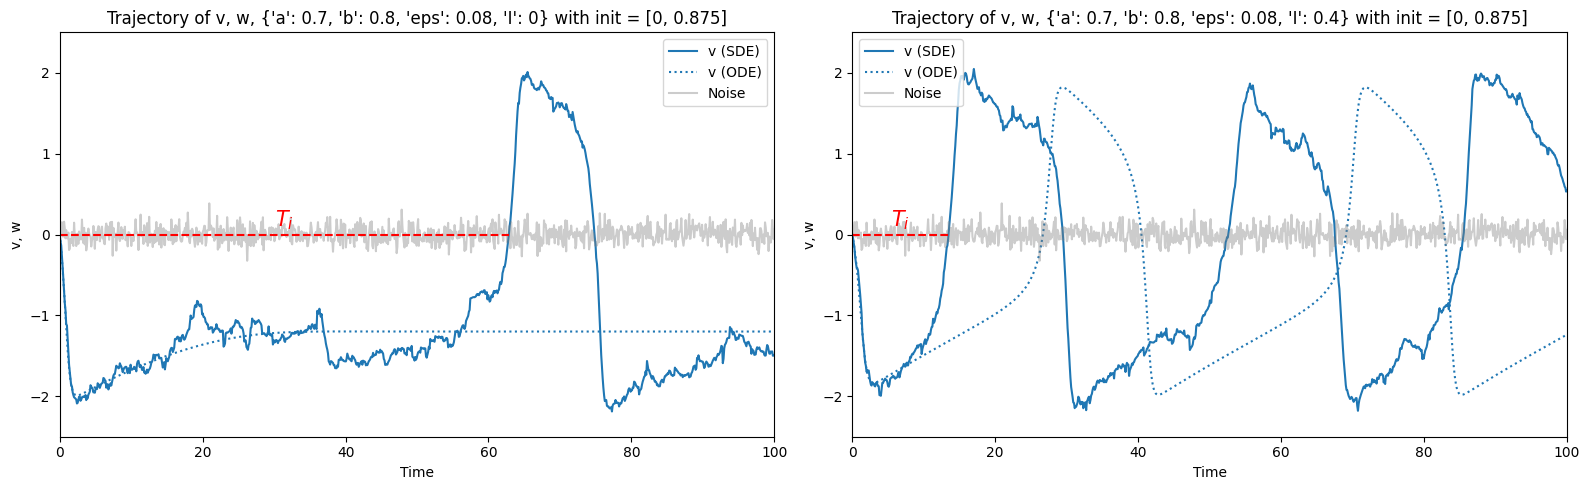

In [519]:
# Draw the trajectories with noise (only second column).
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
for i, param in enumerate(scenarios[:2]):
    for j, ic in enumerate(initial_conditions):
        if j == 1:  # Plot only the second initial condition
            ax[i].set(xlabel='Time', ylabel='v, w', title='Trajectory of v, w, {} with init = {}'.format(param, ic),
                      xlim=(0, time_s[-1]), ylim=(-2.5, 2.5))
            ax[i].plot(time_s, stochastic[i, j][:, 0], label='v (SDE)')
            ax[i].plot(time_s, trajectory[i, j][:, 0], label='v (ODE)', color='C0', ls=":")

            # Generate and plot noise trajectory
            np.random.seed(42)  # Set a seed for reproducibility
            noise_traj = np.array([white_noise_flow(0, 1, sigma=0.1) for t in time_s])
            ax[i].plot(time_s, noise_traj, label='Noise', alpha=0.4, color='gray')

            # Find the time of the first spike (time when v exceeds 0)
            first_spike_time = time_s[np.argmax(stochastic[i, j][:, 0] > 0)]

            # Plot the red dashed line segment from 0 to the first spike time
            ax[i].plot([0, first_spike_time], [0, 0], color='red', linestyle='dashed')

            # Add T_i equation above the segment with larger font size
            ax[i].text((first_spike_time + 0) / 2, 0.1, r'$T_i$', color='red', ha='center', fontsize=15)

            ax[i].legend()

            # Print the value of T
            print(f"Time of the first spike (T_i): {first_spike_time:.2f}")

plt.tight_layout()
plt.show()
